In [91]:
import os,sys
import pandas as pd
import numpy as np
import causality
import numpy
from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest
import matplotlib.pyplot as plt
from causality.nonparametric.causal_reg import AdjustForDirectCauses
from networkx import DiGraph
import networkx as nx
from datetime import datetime
from anew_module import anew
%matplotlib inline

In [105]:
anew.sentiment("These Are Our Memories Of London's Terrorist Attacks")['valence']

0.0

In [108]:
data = pd.read_csv('buzzfeed_facebook_statuses.csv')

In [109]:
data['status_message'].iloc[1]

'Warning: GRAPHIC, because, ya know, birth.'

In [110]:
data.columns

Index([u'status_id', u'status_message', u'link_name', u'status_type',
       u'status_link', u'status_published', u'num_likes', u'num_comments',
       u'num_shares'],
      dtype='object')

In [111]:
data['date'] = map(lambda x: x[:10],data['status_published'])

In [112]:
(data['num_likes']).describe()

count     18064.000000
mean       6091.658326
std       15430.495934
min           0.000000
25%         219.000000
50%        1733.000000
75%        6593.500000
max      943454.000000
Name: num_likes, dtype: float64

In [113]:
data[['Year','Month','Date']] = data['status_published'].apply(lambda x: pd.Series(x[:10].split('-')))

In [114]:
data = data[data['Year']=='2015']

In [115]:
data1 = data[::-1]

In [120]:
len_month_feeds = []
for i in range(1,8):
    per_month = 'x'+str(i)
    globals()[per_month] = list(data1[data1['Month'] == '0'+str(i)]['num_likes'])
    len_month_feeds.append(len(globals()[per_month]))
    

243
243
243
243
243
243
243


In [165]:
min_n = min(len_month_feeds)
print min_n
print len_month_feeds

373
[703, 706, 932, 1005, 700, 634, 373]


In [166]:
l = [1,2,3,4,5,6]
l[-4:]

[3, 4, 5, 6]

In [167]:
X = pd.DataFrame({'x1' : x1[:min_n], 'x2' : x2[:min_n], 'x3' : x3[:min_n], 'x4' : x4[:min_n], 'x5' : x5[:min_n],\
                 'x6' : x6[:min_n], 'x7' : x7[:min_n]})

In [168]:
variable_types = {'x1' : 'c', 'x2' : 'c', 'x3' : 'c', 'x4' : 'c', 'x5' : 'c','x6' : 'c','x7' : 'c'}

# run the search
ic_algorithm = IC(RobustRegressionTest, X, variable_types)
graph = ic_algorithm.search()

In [169]:
graph.edges(data=True)

[('x2', 'x3', {'arrows': [], 'marked': False}),
 ('x2', 'x1', {'arrows': [], 'marked': False}),
 ('x2', 'x6', {'arrows': [], 'marked': False}),
 ('x2', 'x7', {'arrows': [], 'marked': False}),
 ('x2', 'x4', {'arrows': [], 'marked': False}),
 ('x2', 'x5', {'arrows': [], 'marked': False}),
 ('x3', 'x7', {'arrows': [], 'marked': False}),
 ('x3', 'x4', {'arrows': ['x4'], 'marked': False}),
 ('x3', 'x5', {'arrows': ['x5'], 'marked': False}),
 ('x1', 'x6', {'arrows': [], 'marked': False}),
 ('x1', 'x7', {'arrows': [], 'marked': False}),
 ('x1', 'x4', {'arrows': ['x4'], 'marked': False}),
 ('x1', 'x5', {'arrows': ['x5'], 'marked': False}),
 ('x6', 'x7', {'arrows': [], 'marked': False}),
 ('x6', 'x4', {'arrows': ['x6'], 'marked': True}),
 ('x6', 'x5', {'arrows': ['x6'], 'marked': True}),
 ('x7', 'x4', {'arrows': [], 'marked': False}),
 ('x7', 'x5', {'arrows': [], 'marked': False}),
 ('x4', 'x5', {'arrows': [], 'marked': False})]

In [170]:
to_plot = map(lambda x: (x[0],x[1]) if (x[2]['arrows']!=[]) else (x[1],x[0]),graph.edges(data=True))

In [171]:
to_plot

[('x3', 'x2'),
 ('x1', 'x2'),
 ('x6', 'x2'),
 ('x7', 'x2'),
 ('x4', 'x2'),
 ('x5', 'x2'),
 ('x7', 'x3'),
 ('x3', 'x4'),
 ('x3', 'x5'),
 ('x6', 'x1'),
 ('x7', 'x1'),
 ('x1', 'x4'),
 ('x1', 'x5'),
 ('x7', 'x6'),
 ('x6', 'x4'),
 ('x6', 'x5'),
 ('x4', 'x7'),
 ('x5', 'x7'),
 ('x5', 'x4')]

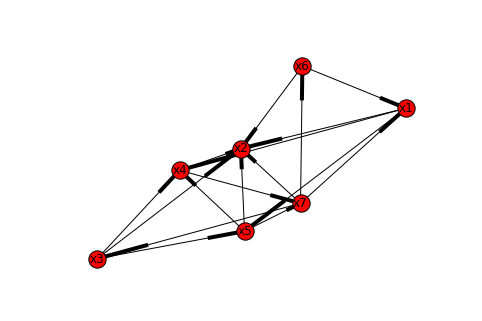

In [172]:
from causality.nonparametric.causal_reg import AdjustForDirectCauses
from networkx import DiGraph

g = DiGraph()

g.add_nodes_from(['x1','x2','x3','x4', 'x5','x6','x7'])
g.add_edges_from([('x3', 'x2'),('x1', 'x2'),('x6', 'x2'),('x7', 'x2'),('x4', 'x2'),('x5', 'x2'),('x7', 'x3'),\
                  ('x3', 'x4'),('x3', 'x5'),('x6', 'x1'),('x7', 'x1'),('x1', 'x4'),('x1', 'x5'),('x7', 'x6'),\
                  ('x4', 'x7'),('x5', 'x7'),('x5', 'x4')])
nx.draw(g,with_labels = True)